# Cifar10

In this exercise we will try to create a CNN that will classify not 2 but 10 different image labels. We get the images from the dataset named [Cifar10](http://www.cs.utoronto.ca/~kriz/cifar.html) 

* Import :
  * Tensorflow
  * Numpy 
  * Matplotlib.pyplot 

In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
tf.__version__

'2.8.0'

* Using `tf.keras.utils.get_file` load the image files into your storage with this link `https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/train.zip`

In [2]:
# First we download the .zip file containing all the images
tf.keras.utils.get_file("/content/cifar10.zip",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/train.zip",
                        extract=True,
                        cache_subdir="/content")

'C:/content/cifar10.zip'

* Import the dataframe containing the labels from this link `https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/trainLabels.csv`

In [3]:
# Then the DataFrame containing the name of the image files and the value of the 
# target variable
import pandas as pd
data = pd.read_csv("https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/trainLabels.csv")
data.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


* Turn the `id` column into string type and add `.png` at the end of each string for the filenames to be complete

In [4]:
data["id"] = data["id"].astype("str") + ".png"
data.head()

,id,label
0,1.png,frog
1,2.png,truck
2,3.png,truck
3,4.png,deer
4,5.png,automobile


* Load and display an image of your dataset 

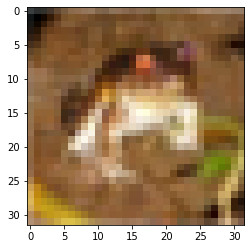

In [5]:
# Visualize a random picture
img = tf.io.read_file("/content/train/1.png")
img = tf.image.decode_png(img, channels=3)
plt.imshow(img)

* View a random image of each of your labels in your dataset * View a random image of each of your labels in your dataset 

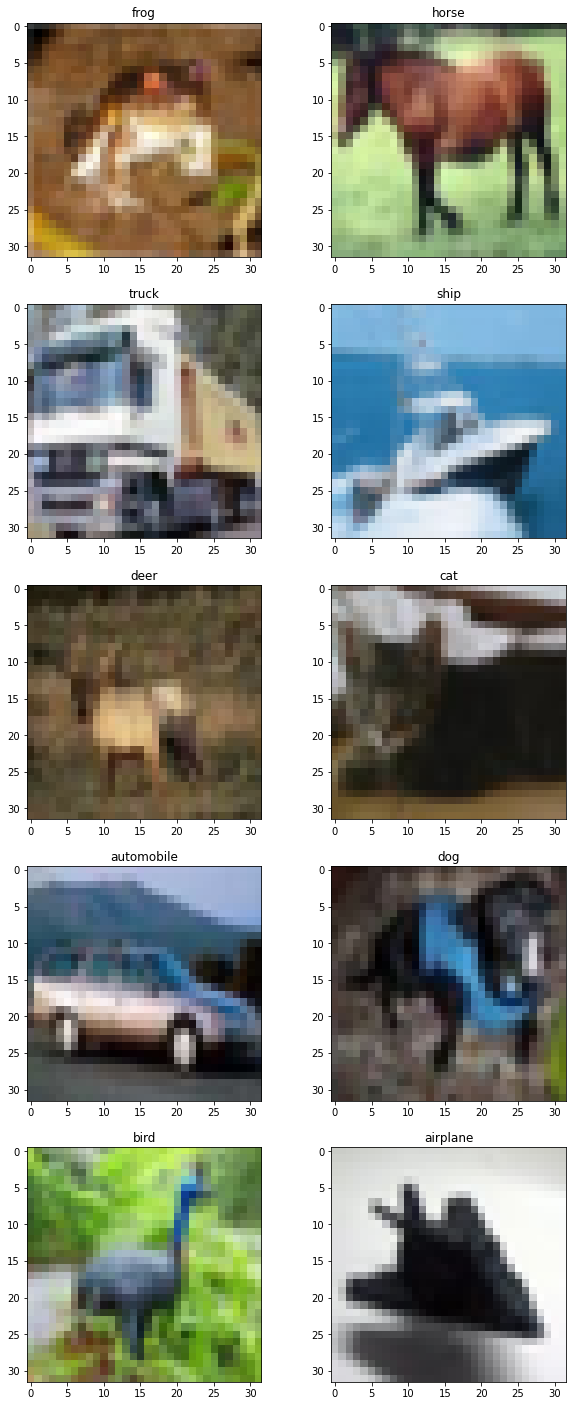

In [6]:
data_per_label = data.loc[data["label"].duplicated()==False]
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,25))
for i in range(5):
  for j in range(2):
    filename = "/content/train/" + data_per_label.iloc[i+j*5,0]
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels=3)
    axes[i,j].imshow(img)
    axes[i,j].title.set_text(data_per_label.iloc[i+j*5,1])

* Define an instance of an `ImageDataGenerator` Class with the data augmentation parameters of your choice, and `validation_split=0.3` (In the correction we will use data augmentation parameters that do not force us to fill empty pixels with new values)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_generator = ImageDataGenerator(
    rotation_range=0, # Angle range for random image rotation
    width_shift_range=0.0, # Random shift of the image along width axis
    height_shift_range=0.0, # Random shift of the image along height axis
    brightness_range=(0.5,1), # Random brightness modification
    shear_range=0.0, # Random distortion of the image
    zoom_range=0.0, # Random zoom on the image
    channel_shift_range=50.0, # Random hue modification
    horizontal_flip=True, # Randomly flips image horizontally
    vertical_flip=True, # Randomly flips image virtically
    rescale=1/255., # Rescaling values from [0,255]->[0,1]
    fill_mode='wrap',
    validation_split=0.3 # Portion of the data that can be saved for validation
)

* Set up one generator for the train data and one for the test data using the method that lets you generate data with a dataframe. Since we have many images in this dataset, we will create large batches of 64 images.
Use a target size of `(32,32)` and class_mode `"sparse"`

In [8]:
train_generator = img_generator.flow_from_dataframe(
    dataframe=data, # the dataframe containing the filename and label column
    directory="/content/train", # the directory containing the image files
    x_col="id", # the name of the column with the filenames
    y_col="label", # the name of the column with the labels
    target_size=(32,32),
    class_mode = "sparse", 
    batch_size=64, 
    shuffle = True,
    subset = "training"
)

val_generator = img_generator.flow_from_dataframe(
    dataframe=data, # the dataframe containing the filename and label column
    directory="/content/train", # the directory containing the image files
    x_col="id", # the name of the column with the filenames
    y_col="label", # the name of the column with the labels
    target_size=(32,32),
    class_mode = "sparse", 
    batch_size=64, 
    shuffle = True,
    subset = "validation"
)

Found 35000 validated image filenames belonging to 10 classes.
Found 15000 validated image filenames belonging to 10 classes.


* Display a batch of data of train data

C:\Users\Berenger\AppData\Local\Temp/ipykernel_17940/629457431.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


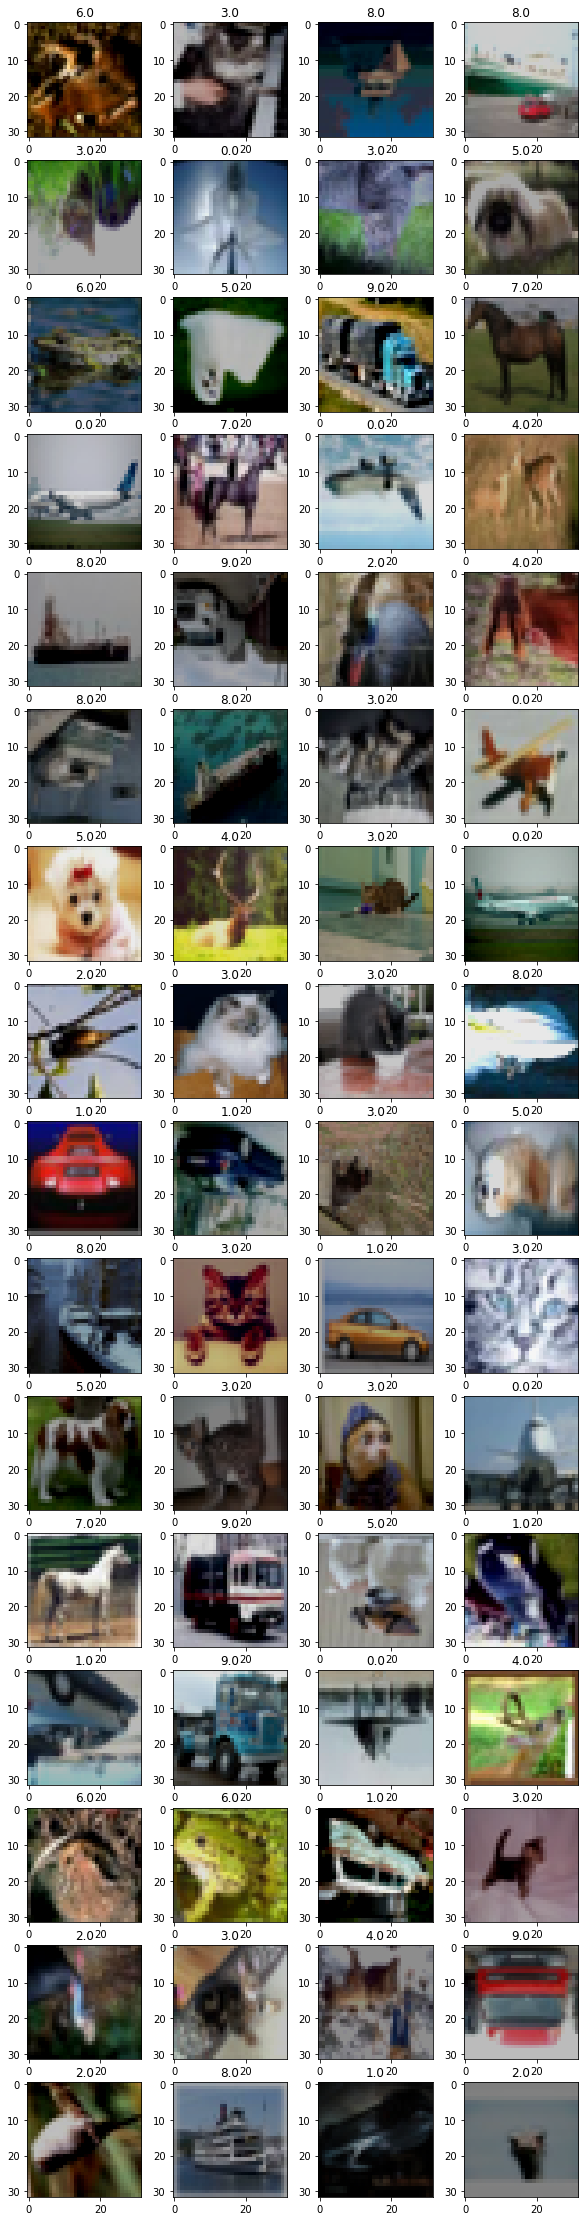

In [9]:
imgs, targets = next(iter(train_generator))
fig, ax = plt.subplots(16,4, figsize=(10,40))
for i, (img, target) in enumerate(zip(imgs, targets)):
  ax[i-16*(i//16),i//16].imshow(img)
  ax[i-16*(i//16),i//16].title.set_text(str(target))
fig.show()

* How many times can you divide the images by two along each axis until you reduce the images to single pixel?

In [10]:
a = 32
while a>1 :
  print(a, "->" , a/2)
  a=a/2

32 -> 16.0
16.0 -> 8.0
8.0 -> 4.0
4.0 -> 2.0
2.0 -> 1.0


5 times!

* Build a neural network with a single convolution layer with 32 neurons, kernel size `(3,3)`, padding `"same"`, and activation `"relu"`, a max pooling layer, a flatten layer, then finish up the network with a dense layer that can predict the target variable.

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 10)                81930     
                                                                 
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


* Compile the model using the right loss function and metric(s) and the Adam optimizer with default learning rate

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

* Train the model over 50 epochs

In [13]:
model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
547/547 [==============================] - 311s 566ms/step - loss: 1.8425 - sparse_categorical_accuracy: 0.3503 - val_loss: 1.7313 - val_sparse_categorical_accuracy: 0.3925
Epoch 2/10
547/547 [==============================] - 64s 117ms/step - loss: 1.6845 - sparse_categorical_accuracy: 0.4111 - val_loss: 1.6321 - val_sparse_categorical_accuracy: 0.4298
Epoch 3/10
547/547 [==============================] - 77s 142ms/step - loss: 1.6070 - sparse_categorical_accuracy: 0.4409 - val_loss: 1.5701 - val_sparse_categorical_accuracy: 0.4441
Epoch 4/10
547/547 [==============================] - 67s 122ms/step - loss: 1.5539 - sparse_categorical_accuracy: 0.4592 - val_loss: 1.5184 - val_sparse_categorical_accuracy: 0.4701
Epoch 5/10
547/547 [==============================] - 64s 117ms/step - loss: 1.5090 - sparse_categorical_accuracy: 0.4750 - val_loss: 1.5680 - val_sparse_categorical_accuracy: 0.4535
Epoch 6/10
547/547 [==============================] - 64s 118ms/step - loss: 1.4758 

* Save the model under `cifar10model1conv.h5`

In [14]:
model.save("/content/cifar10model1conv.h5")

* Use the following code to save the model's history (it does not get saved with the model)

In [15]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/cifar10model1convhistory.json", 'w'))

* You may get the model's history with this code (for instructors not to have to train the whole model during the session)

In [16]:
tf.keras.utils.get_file("/content/cifar10model1convhistory.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model1convhistory.json")

'C:/content/cifar10model1convhistory.json'

* Load the history .json file using the following command (for instructors)

In [17]:
history_dict = json.load(open("/content/cifar10model1convhistory.json", 'r'))

* Load the previously saved model using the two following commands (for instructors)

In [18]:
tf.keras.utils.get_file("/content/cifar10model1conv.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model1conv.h5")

'C:/content/cifar10model1conv.h5'

In [19]:
model = tf.keras.models.load_model("/content/cifar10model1conv.h5")

* Display the evolution of the loss and the validation loss using plotly

In [20]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

The model looks it starts to overfit after 30 epochs and it trains smoothly on the training data.

* Build a new model and add a new convolution layer with double the number of neurons on it followed by a max pooling, and reproduce all the same steps as before.

In [21]:
model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Conv2D(64, (3,3), padding="same"),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 10)               

In [22]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [23]:
model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
547/547 [==============================] - 67s 122ms/step - loss: 1.7545 - sparse_categorical_accuracy: 0.3791 - val_loss: 1.5749 - val_sparse_categorical_accuracy: 0.4494
Epoch 2/10
547/547 [==============================] - 72s 131ms/step - loss: 1.4817 - sparse_categorical_accuracy: 0.4844 - val_loss: 1.3930 - val_sparse_categorical_accuracy: 0.5181
Epoch 3/10
547/547 [==============================] - 72s 132ms/step - loss: 1.3795 - sparse_categorical_accuracy: 0.5203 - val_loss: 1.3495 - val_sparse_categorical_accuracy: 0.5290
Epoch 4/10
547/547 [==============================] - 85s 155ms/step - loss: 1.3248 - sparse_categorical_accuracy: 0.5450 - val_loss: 1.3241 - val_sparse_categorical_accuracy: 0.5439
Epoch 5/10
547/547 [==============================] - 74s 135ms/step - loss: 1.2864 - sparse_categorical_accuracy: 0.5569 - val_loss: 1.2660 - val_sparse_categorical_accuracy: 0.5603
Epoch 6/10
547/547 [==============================] - 82s 151ms/step - loss: 1.2539 -

In [24]:
model.save("/content/cifar10model2conv.h5")

import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/cifar10model2convhistory.json", 'w'))

In [25]:
tf.keras.utils.get_file("/content/cifar10model2convhistory.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model2convhistory.json")
tf.keras.utils.get_file("/content/cifar10model2conv.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model2conv.h5")
history_dict = json.load(open("/content/cifar10model2convhistory.json", 'r'))
model = tf.keras.models.load_model("/content/cifar10model2conv.h5")

In [26]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

Here it seems pretty clear that just by adding a second convolutional layer in our network we are able to reach lower values of the loss function in fewer epochs, and despite the fact that our second model has much fewer parameters!

* Repeat the same steps adding a third convolutional layer with `128` neurons on it, followed my a max pooling layer.

In [27]:
model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Conv2D(64, (3,3), padding="same"),
     MaxPool2D(),
     Conv2D(128, (3,3), padding="same"),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 128)       

In [28]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])
model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
547/547 [==============================] - 109s 199ms/step - loss: 1.6843 - sparse_categorical_accuracy: 0.4067 - val_loss: 1.4639 - val_sparse_categorical_accuracy: 0.4791
Epoch 2/10
547/547 [==============================] - 71s 130ms/step - loss: 1.3727 - sparse_categorical_accuracy: 0.5235 - val_loss: 1.3291 - val_sparse_categorical_accuracy: 0.5417
Epoch 3/10
547/547 [==============================] - 66s 120ms/step - loss: 1.2582 - sparse_categorical_accuracy: 0.5645 - val_loss: 1.2232 - val_sparse_categorical_accuracy: 0.5783
Epoch 4/10
547/547 [==============================] - 66s 120ms/step - loss: 1.1816 - sparse_categorical_accuracy: 0.5949 - val_loss: 1.1613 - val_sparse_categorical_accuracy: 0.5961
Epoch 5/10
547/547 [==============================] - 67s 122ms/step - loss: 1.1259 - sparse_categorical_accuracy: 0.6151 - val_loss: 1.1532 - val_sparse_categorical_accuracy: 0.6029
Epoch 6/10
547/547 [==============================] - 60s 110ms/step - loss: 1.0875 

In [29]:
model.save("/content/cifar10model3conv.h5")

import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/cifar10model3convhistory.json", 'w'))

In [30]:
tf.keras.utils.get_file("/content/cifar10model3convhistory.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model3convhistory.json")
tf.keras.utils.get_file("/content/cifar10model3conv.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model3conv.h5")
history_dict = json.load(open("/content/cifar10model3convhistory.json", 'r'))
model = tf.keras.models.load_model("/content/cifar10model3conv.h5")

In [31]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

* Let's build the same model and double the number of convolutional neurons on each layer.

In [32]:
model = Sequential(
    [
     Conv2D(64, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Conv2D(128, (3,3), padding="same"),
     MaxPool2D(),
     Conv2D(256, (3,3), padding="same"),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 256)       

In [33]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(), 
              metrics=[SparseCategoricalAccuracy()])
model.fit(train_generator, epochs=50, validation_data=val_generator)

Epoch 1/50
547/547 [==============================] - 95s 172ms/step - loss: 1.6206 - sparse_categorical_accuracy: 0.4242 - val_loss: 1.3502 - val_sparse_categorical_accuracy: 0.5297
Epoch 2/50
547/547 [==============================] - 95s 173ms/step - loss: 1.3093 - sparse_categorical_accuracy: 0.5463 - val_loss: 1.2674 - val_sparse_categorical_accuracy: 0.5613
Epoch 3/50
547/547 [==============================] - 95s 173ms/step - loss: 1.1941 - sparse_categorical_accuracy: 0.5898 - val_loss: 1.1873 - val_sparse_categorical_accuracy: 0.5847
Epoch 4/50
547/547 [==============================] - 95s 174ms/step - loss: 1.1129 - sparse_categorical_accuracy: 0.6216 - val_loss: 1.1301 - val_sparse_categorical_accuracy: 0.6140
Epoch 5/50
547/547 [==============================] - 95s 174ms/step - loss: 1.0598 - sparse_categorical_accuracy: 0.6400 - val_loss: 1.2228 - val_sparse_categorical_accuracy: 0.5847
Epoch 6/50
547/547 [==============================] - 95s 173ms/step - loss: 1.0108 -

In [34]:
model.save("/content/cifar10model4conv.h5")

import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/cifar10model4convhistory.json", 'w'))

In [35]:
tf.keras.utils.get_file("/content/cifar10model4convhistory.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model4convhistory.json")
tf.keras.utils.get_file("/content/cifar10model4conv.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model4conv.h5")
history_dict = json.load(open("/content/cifar10model4convhistory.json", 'r'))
model = tf.keras.models.load_model("/content/cifar10model4conv.h5")

In [36]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

Increasing the number of neurons on each layer is causing the model to quickly overfit! But it trains really on the training data.

* In the time remaining, build a model by duplicating the convolutional layers before every maxpooling adn go back to the original number of neurons. Look at the model summary for reference. This last model will have 6 different convolutional layers, let's see the effect of this on the predictions

In [37]:
model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     Conv2D(32, (3,3), padding="same"),
     MaxPool2D(),
     Conv2D(64, (3,3), padding="same"),
     Conv2D(64, (3,3), padding="same"),
     MaxPool2D(),
     Conv2D(128, (3,3), padding="same"),
     Conv2D(128, (3,3), padding="same"),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                 

In [38]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(), 
              metrics=[SparseCategoricalAccuracy()])
model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
547/547 [==============================] - 111s 201ms/step - loss: 1.6467 - sparse_categorical_accuracy: 0.4137 - val_loss: 1.4875 - val_sparse_categorical_accuracy: 0.4959
Epoch 2/10
547/547 [==============================] - 111s 204ms/step - loss: 1.3043 - sparse_categorical_accuracy: 0.5444 - val_loss: 1.2766 - val_sparse_categorical_accuracy: 0.5544
Epoch 3/10
547/547 [==============================] - 110s 202ms/step - loss: 1.1932 - sparse_categorical_accuracy: 0.5891 - val_loss: 1.2268 - val_sparse_categorical_accuracy: 0.5669
Epoch 4/10
547/547 [==============================] - 111s 203ms/step - loss: 1.1198 - sparse_categorical_accuracy: 0.6151 - val_loss: 1.0968 - val_sparse_categorical_accuracy: 0.6238
Epoch 5/10
547/547 [==============================] - 111s 203ms/step - loss: 1.0677 - sparse_categorical_accuracy: 0.6311 - val_loss: 1.1607 - val_sparse_categorical_accuracy: 0.6066
Epoch 6/10
547/547 [==============================] - 110s 202ms/step - loss: 1.

In [39]:
model.save("/content/cifar10model5conv.h5")

import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/cifar10model5convhistory.json", 'w'))

In [40]:
tf.keras.utils.get_file("/content/cifar10model5convhistory.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model5convhistory.json")
tf.keras.utils.get_file("/content/cifar10model5conv.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model5conv.h5")
history_dict = json.load(open("/content/cifar10model5convhistory.json", 'r'))
model = tf.keras.models.load_model("/content/cifar10model5conv.h5")

In [41]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

Adding more convolutional layers helps a little but does not really improve the results for this dataset.